In [1]:
from scipy.spatial import Voronoi, voronoi_plot_2d

import alphashape as ap

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["figure.dpi"] = 150

import pandas as pd
from colour import Color
import os

import Visualization as vis

In [2]:
# Now read in the data
locationFile = 'Location_20.csv'
communityFolder = 'communities'
dataFrame = pd.read_csv(locationFile)

# Read in the different communities we have
communityFiles = os.listdir(communityFolder)
communityArr = []
for file in communityFiles:
    if 'csv' in file:
        currComm = np.genfromtxt(f'{communityFolder}/{file}', dtype='int')
        # Make sure that we have a continuous set of integer labels for our communities
        # ie take [1, 4, 7, 3, 2, 6] -> [0, 3, 5, 2, 1, 4]
        uniqueCommunities = np.unique(currComm)
        replaceDict = dict(zip(uniqueCommunities, range(len(currComm))))
        currComm = np.array([replaceDict[c] for c in currComm])
        # Now make sure we don't have empty communities
        # and that they are the same length as our position data
        # I am not sure why there are entries that aren't the same length...
        if np.sum(currComm) != 0 and len(currComm) == len(dataFrame["x"]):
            communityArr.append(currComm)
        
communityArr = np.array(communityArr)
#for c in communityArr:
#    print(len(c))
print(communityArr)
# Generate the voronoi tesselation
points = np.zeros([len(dataFrame["x"]), 2])
points[:,0] = dataFrame["x"]
points[:,1] = dataFrame["y"]

mapVor = Voronoi(points)

[[  0   0   1 ... 111  44 115]
 [  0   0   1 ... 490 506 511]
 [  0   0   1 ... 164 176 179]
 ...
 [  0   0   0 ...   0   0  34]
 [  0   0   1 ... 234 253 254]
 [  0   0   1 ... 567 593 601]]


In [3]:
# Find the total boundary around the shape
# The .80 is to say that we don't want the boundary to be crazy angular
alpha = 0.80 * ap.optimizealpha(points)
hull = ap.alphashape(points, alpha)
hullPoints = hull.exterior.coords.xy

# And convert to a better format
hullPoints = [hullPoints[0].tolist(), hullPoints[1].tolist()]

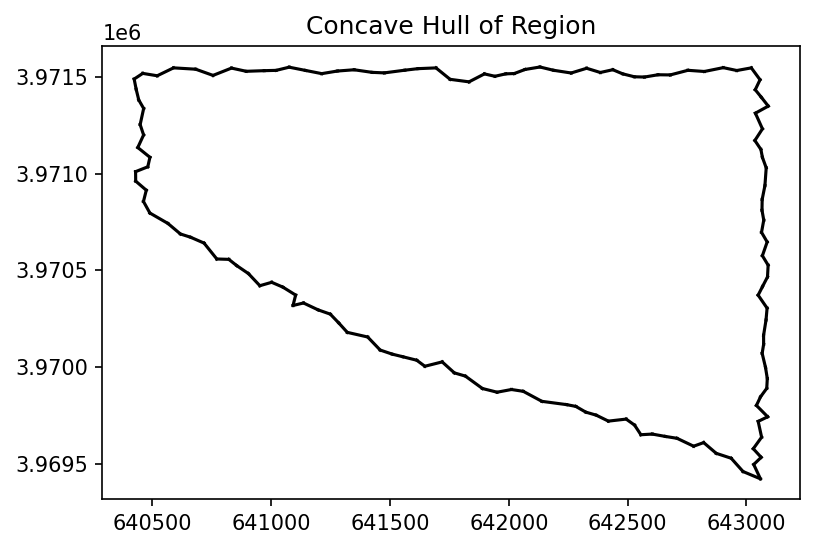

In [4]:
# Transform to looking at the lines of the hull (instead of the points)
hullLines = np.zeros([len(hullPoints[0]), 2, 2])

for i in range(len(hullPoints[0])):
    # Each of these lines are of the form:
    # [[x1, x2], [y1, y2]]
    hullLines[i] = [[hullPoints[0][i], hullPoints[0][(i+1)%len(hullPoints[0])]],
                    [hullPoints[1][i], hullPoints[1][(i+1)%len(hullPoints[0])]]]
    
# And draw the hull
fig, ax = plt.subplots()
vis.drawLines(ax, hullLines)
plt.title("Concave Hull of Region")
plt.show()

/home/jack/workspaces/jupyter-workspace/CommunityDetection/Visualization.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  s = ((x[4]-x[3])*(y[3]-y[1]) - (x[3]-x[1])*(y[4] - y[3])) / denominator
/home/jack/workspaces/jupyter-workspace/CommunityDetection/Visualization.py:31: RuntimeWarning: invalid value encountered in double_scalars
  t = ((x[2]-x[1])*(y[3]-y[1]) - (x[3]-x[1])*(y[2] - y[1])) / denominator
/home/jack/workspaces/jupyter-workspace/CommunityDetection/Visualization.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  s = ((x[4]-x[3])*(y[3]-y[1]) - (x[3]-x[1])*(y[4] - y[3])) / denominator
/home/jack/workspaces/jupyter-workspace/CommunityDetection/Visualization.py:31: RuntimeWarning: invalid value encountered in double_scalars
  t = ((x[2]-x[1])*(y[3]-y[1]) - (x[3]-x[1])*(y[2] - y[1])) / denominator
/home/jack/workspaces/jupyter-workspace/CommunityDetection/Visualization.py:29: RuntimeWarning: divide by zero encountered in double_scalars
 

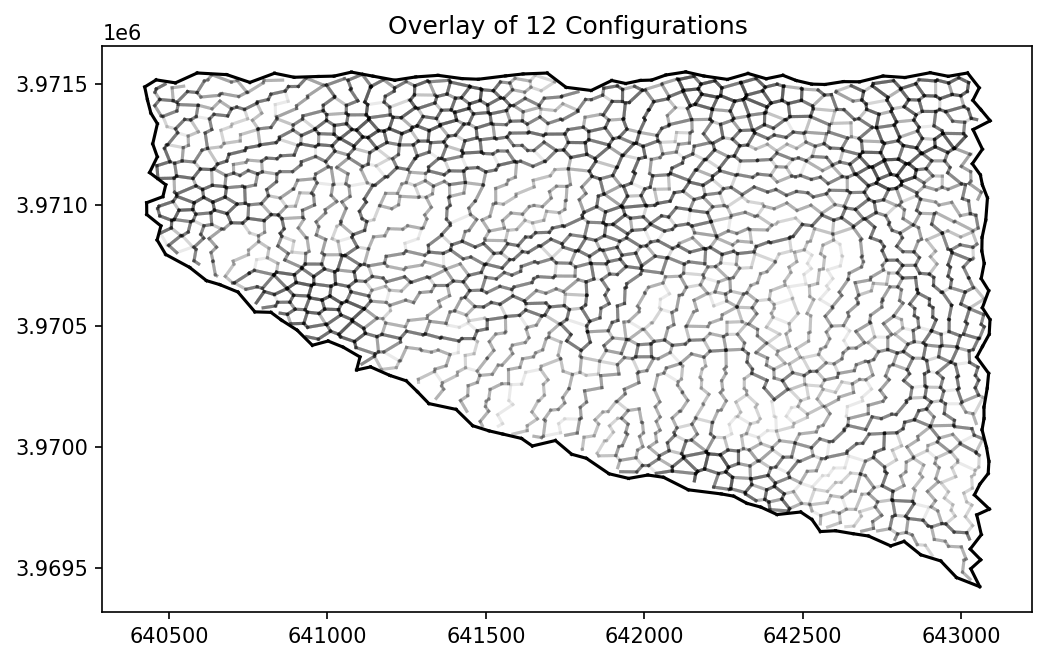

In [7]:
# Now we want to draw the internal boundaries, which will vary based on the communities
# First, just draw all of the on top of each other (with some opacity)
opacity = 1/len(communityArr)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

colors = vis.genRandomColors(len(communityArr))

for i in range(len(communityArr)):
    boundaryLines = vis.cullVoronoi(mapVor, communityArr[i], hullLines)
    vis.drawLines(ax, boundaryLines, opacity=opacity)

vis.drawLines(ax, hullLines)
plt.title(f"Overlay of {len(communityArr)} Configurations")
plt.savefig("config_overlay.png")
plt.show()